In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.cm import jet
%matplotlib inline

In [3]:
from background import NodeAndTimeAndMarkBackground, UniformTimeBackground, GaussianBackground, TimeAndMarkBackground
from clusters import NodeAndTimeAndMarkCluster, ExponentialTimeCluster, GaussianCluster, DefaultClusterFactory, TimeAndMarkCluster
from models import DirichletProcessMixtureModel, NeymanScottModel
from util import permute_to_match, onehot, compute_state_overlap

In [4]:
npr.seed(0)

In [5]:
# # Make a Neyman-Scott model with gaussian marks
# T = 100           # time window
# M = 10             # number of nodes
# data_dim = 2      # dimensionality of marks (e.g. vocab size in multinomial model)
# lmbda0 = 100      # background rate of events (across all nodes)
# tau = 5           # time constant of exponential impulse responses
# mu = 20           # rate of latent events
# alpha = 10         # shape of gamma prior on latent event weights
# beta = 10/20       # rate of gamma prior on latent event weights

# # specify hyperparameters of cluster marks
# niw_hypers = dict(mu0=np.zeros(data_dim),
#                   lmbda=0.01,
#                   Psi=(data_dim + 1000 - 1) * np.eye(data_dim),
#                   nu=data_dim+1000)



In [6]:
# Make a Neyman-Scott model with gaussian marks
T = 100           # time window
M = 10             # number of nodes
data_dim = 5      # dimensionality of marks (e.g. vocab size in multinomial model)
lmbda0 = 100      # background rate of events (across all nodes)
tau = 5           # time constant of exponential impulse responses
mu = 20           # rate of latent events
alpha = 1         # shape of gamma prior on latent event weights
beta = alpha/20       # rate of gamma prior on latent event weights

# specify hyperparameters of cluster marks
niw_hypers = dict(mu0=np.zeros(data_dim),
                  lmbda=0.1,
                  Psi=(data_dim + 1 - 1) * np.eye(data_dim),
                  nu=data_dim+1)

In [7]:
# bkgd_class = GaussianBackground
# bkgd_hypers = dict(
#     dict(data_dim=data_dim),
#     )

# cluster_class = GaussianCluster
# cluster_hypers = niw_hypers

# bkgd_class = TimeAndMarkBackground
# bkgd_hypers = dict(
#     time_class=UniformTimeBackground,
#     time_kwargs=dict(T=T),
#     mark_class=GaussianBackground,
#     mark_kwargs=dict(data_dim=data_dim),
#     )

# cluster_class = TimeAndMarkCluster
# cluster_hypers = dict(
#     time_class=ExponentialTimeCluster,
#     time_kwargs=dict(T=T, tau=tau),
#     mark_class=GaussianCluster,
#     mark_kwargs=niw_hypers,
#     )

# bkgd_class = UniformTimeBackground
# bkgd_hypers = dict(T=T)

# cluster_class = ExponentialTimeCluster
# cluster_hypers = dict(T=T, tau=tau)

bkgd_class = NodeAndTimeAndMarkBackground
bkgd_hypers = dict(
    num_nodes=M,
    node_distribution=np.ones(M) / M,
    time_class=UniformTimeBackground,
    time_kwargs=dict(T=T),
    mark_class=GaussianBackground,
    mark_kwargs=dict(data_dim=data_dim),
    )

cluster_class = NodeAndTimeAndMarkCluster
cluster_hypers = dict(
    num_nodes=M,
    node_concentration=0.5,
    time_class=ExponentialTimeCluster,
    time_kwargs=dict(T=T, tau=tau),
    mark_class=GaussianCluster,
    mark_kwargs=niw_hypers,
    )

# Generate synthetic data and compare Gibbs to RJMCMC

In [8]:
true_model = NeymanScottModel(mu, alpha, beta, lmbda0, 
                              bkgd_class(**bkgd_hypers), 
                              DefaultClusterFactory(cluster_class, cluster_hypers))

# Sample from the model
# sample_kwargs = {}
# data, parents, clusters, weights = true_model.generate(**sample_kwargs)

# Sample from the model
sample_kwargs = dict(time_kwargs=dict(), mark_kwargs=dict())
data, parents, clusters, weights = true_model.generate(**sample_kwargs)
times, marks = data[:, 0], data[:, 1:]

# Only keep the valid times
# valid = times < T
valid = np.ones_like(times, dtype=bool)
times = times[valid]
marks = marks[valid]
parents = parents[valid]

# Sort the data by time
perm = np.argsort(times)
times = times[perm]
marks = marks[perm]
parents = parents[perm]
data = np.column_stack((times, marks))

In [9]:
# true_model = NeymanScottModel(mu, alpha, beta, lmbda0, 
#                               bkgd_class(**bkgd_hypers), 
#                               DefaultClusterFactory(cluster_class, cluster_hypers))

# # Sample from the model
# sample_kwargs = dict(time_kwargs=dict(), mark_kwargs=dict())
# data, parents, clusters, weights = true_model.generate(**sample_kwargs)
# nodes, times, marks = data[:, 0], data[:, 1], data[:, 2:]

# # Only keep the valid times
# # valid = times < T
# valid = np.ones_like(times, dtype=bool)
# nodes = nodes[valid]
# times = times[valid]
# marks = marks[valid]
# parents = parents[valid]

# # Sort the data by time
# perm = np.argsort(times)
# nodes = nodes[perm]
# times = times[perm]
# marks = marks[perm]
# parents = parents[perm]
# data = np.column_stack((nodes, times, marks))

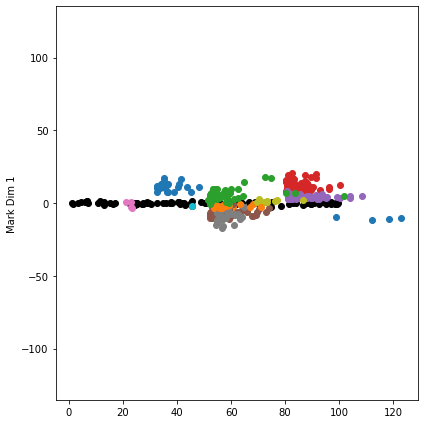

In [10]:
plt.figure(figsize=(6, 6))
ylim = 1.1 * abs(data).max()
for z in np.unique(parents):
    inds = np.where(parents == z)[0]
    plt.plot(data[inds, 1], data[inds, 2], 'o' if z >= 0 else 'ko')

plt.ylabel("Mark Dim 1")
plt.ylim(-ylim, ylim)

plt.tight_layout()

In [22]:
# Fit the correct model
num_samples = 100

# Run the Gibbs sampler with the true hyperparameters
print("true num clusters: ", len(clusters))
print("true lp: ", true_model.log_probability(data, clusters, weights))
gibbs_samples = true_model.gibbs_sample_posterior(data, num_samples=num_samples, init_method="background")

true num clusters:  13
true lp:  -3747.867731429733
Gibbs sampling event parents


num clusters:  13  lp:  -3844.1777135454304
num clusters:  13  lp:  -3850.2685254199787
num clusters:  14  lp:  -3828.1085385974006
num clusters:  12  lp:  -3860.600841955038
num clusters:  13  lp:  -3832.3905237101853
num clusters:  13  lp:  -3843.6874202517592
num clusters:  13  lp:  -3822.732436494114
num clusters:  14  lp:  -3794.9869652072343
num clusters:  13  lp:  -3818.829501567367
num clusters:  13  lp:  -3816.8086873452057
num clusters:  13  lp:  -3811.7946416138698
num clusters:  13  lp:  -3784.1881268257735
num clusters:  15  lp:  -3747.341845807769
num clusters:  14  lp:  -3743.4186106115203
num clusters:  14  lp:  -3755.313461534757
num clusters:  15  lp:  -3741.1195229930904
num clusters:  14  lp:  -3750.917210305493
num clusters:  14  lp:  -3754.507918863406
num clusters:  14  lp:  -3749.760576900267
num clusters:  14  lp:  -3751.107490598054
num clusters:  14  lp:  -3756.407688117466
num clusters:  13  lp:  -3772.5064652269884
num clusters:  14  lp:  -3757.121425564715

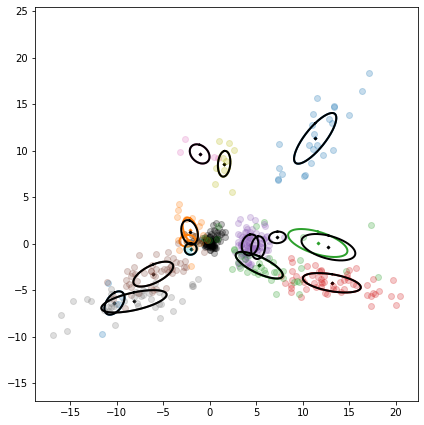

In [15]:
from pybasicbayes.util.plot import plot_gaussian_2D

plt.figure(figsize=(6, 6))
for z in np.unique(parents):
    inds = np.where(parents == z)[0]
    h = plt.plot(data[inds, 2], data[inds, 3], 'o' if z >= 0 else 'ko', alpha=0.25)[0]
    if z >= 0:
        plot_gaussian_2D(clusters[z].mark_cluster.params[0][:2], 
                         clusters[z].mark_cluster.params[1][:2, :2], 
                         color=h.get_color())


for c in gibbs_samples[-1]["clusters"]:
    plot_gaussian_2D(c.mark_cluster.params[0][:2], 
                     c.mark_cluster.params[1][:2, :2], 
                     color='k')
    
plt.axis('equal')
    
plt.tight_layout()

In [24]:
# Fit the correct model with RJMCMC
num_samples = 50000
# nsm = NeymanScottModel(mu, alpha, beta, lmbda0, 
#                        bkgd_class(**bkgd_hypers), 
#                        DefaultClusterFactory(cluster_class, cluster_hypers))

print("true num clusters: ", len(clusters))
print("true lp: ", true_model.log_probability(data, clusters, weights))

rjmcmc_samples = true_model.rjmcmc_sample_posterior(data, num_samples=num_samples, 
                                                    init_method="background")

true num clusters:  13
true lp:  -3747.867731429733


num clusters:  0  lp:  -791935.0596525011
num clusters:  44  lp:  -17208.798690338477
num clusters:  50  lp:  -14658.9410921421
num clusters:  48  lp:  -12839.913911608126
num clusters:  45  lp:  -12106.99845467399
num clusters:  48  lp:  -11965.360157526091
num clusters:  49  lp:  -13168.580343627193
num clusters:  43  lp:  -10889.016936239137
num clusters:  44  lp:  -10700.266804994095
num clusters:  45  lp:  -10587.899217540102
num clusters:  47  lp:  -10469.12633971039
num clusters:  50  lp:  -10225.562813417017
num clusters:  48  lp:  -10088.498106943596
num clusters:  48  lp:  -10087.932578239379
num clusters:  46  lp:  -9821.30292278291
num clusters:  46  lp:  -9841.796294438445
num clusters:  48  lp:  -9642.41361396096
num clusters:  45  lp:  -9489.83211230965
num clusters:  47  lp:  -9488.575004344575
num clusters:  49  lp:  -9516.915701062955
num clusters:  49  lp:  -9492.364674841538
num clusters:  50  lp:  -9557.35629220658
num clusters:  51  lp:  -9583.952664280188
num clu

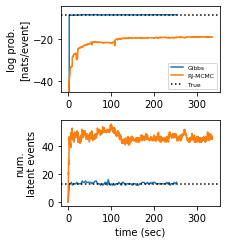

In [55]:
# Get the run time from the progress bars above
gibbs_time = 4 * 60 + 12
rjmcmc_time = 5 * 60 + 35

plt.figure(figsize=(3.25, 3.5))

plt.subplot(211)

# Plot the log joint probability
plt.plot(np.linspace(0, gibbs_time, len(gibbs_samples)),
         np.array([s["log_prob"] for s in gibbs_samples]) / len(data),
        label="Gibbs")
plt.plot(np.linspace(0, rjmcmc_time, len(rjmcmc_samples)),
         np.array([s["log_prob"] for s in rjmcmc_samples]) / len(data),
        label="RJ-MCMC")

xl = plt.xlim()
true_lp = true_model.log_probability(data, clusters, weights)
plt.plot(xl, true_lp / len(data) * np.ones(2), ':k', label="True")
plt.xlim(xl)

# plt.xlabel("time (sec)")
plt.ylabel("log prob.\n[nats/event]")
plt.ylim(-20000 / len(data), -2000 / len(data))
plt.legend(loc="lower right", fontsize=6)

# Plot number of clusters
plt.subplot(212)
plt.plot(np.linspace(0, gibbs_time, len(gibbs_samples)),
         np.array([s["num_clusters"] for s in gibbs_samples]),
        label="Gibbs")
plt.plot(np.linspace(0, rjmcmc_time, len(rjmcmc_samples)),
         np.array([s["num_clusters"] for s in rjmcmc_samples]),
        label="RJ-MCMC")

# Plot the true likelihood
xl = plt.xlim()
plt.plot(xl, len(clusters) * np.ones(2), ':k', label="True")
plt.xlim(xl)

plt.xlabel("time (sec)")
plt.ylabel("num.\nlatent events")
# plt.legend(loc="center right")

plt.tight_layout()

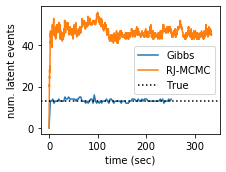

In [47]:
# Plot the number of clusters
plt.figure(figsize=(3.25, 2.5))
plt.plot(np.linspace(0, gibbs_time, len(gibbs_samples)),
         np.array([s["num_clusters"] for s in gibbs_samples]),
        label="Gibbs")
plt.plot(np.linspace(0, rjmcmc_time, len(rjmcmc_samples)),
         np.array([s["num_clusters"] for s in rjmcmc_samples]),
        label="RJ-MCMC")

# Plot the true likelihood
xl = plt.xlim()
plt.plot(xl, len(clusters) * np.ones(2), ':k', label="True")
plt.xlim(xl)

plt.xlabel("time (sec)")
plt.ylabel("num. latent events")
# plt.ylim(-20000 / len(data), -2000 / len(data))
plt.legend(loc="center right")

plt.tight_layout()

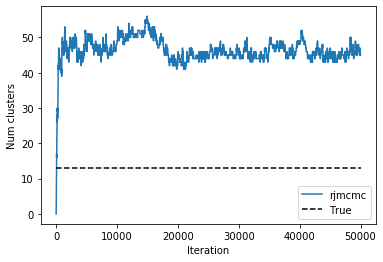

In [28]:
# Plot the number of clusters over samples
plt.figure()
# plt.plot([s["num_clusters"] for s in gibbs_samples], label="gibbs")
plt.plot([s["num_clusters"] for s in rjmcmc_samples], label="rjmcmc")
plt.plot([0, len(rjmcmc_samples)], [len(clusters), len(clusters)], '--k', label="True")
plt.xlabel("Iteration")
plt.ylabel("Num clusters")
plt.legend(loc="lower right")
plt.show()

(array([0.09583333, 0.56833333, 0.        , 0.44833333, 0.        ,
        0.31166667, 0.135     , 0.        , 0.08083333, 0.02666667]),
 array([44. , 44.6, 45.2, 45.8, 46.4, 47. , 47.6, 48.2, 48.8, 49.4, 50. ]),
 <a list of 10 Patch objects>)

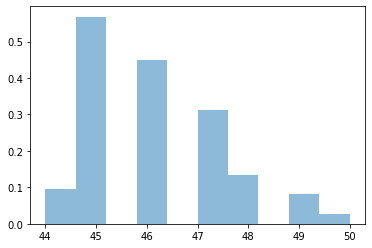

In [29]:
# plt.hist([s["num_clusters"] for s in gibbs_samples[25:]], density=True, alpha=0.5)
plt.hist([s["num_clusters"] for s in rjmcmc_samples[-2000:]], density=True, alpha=0.5)

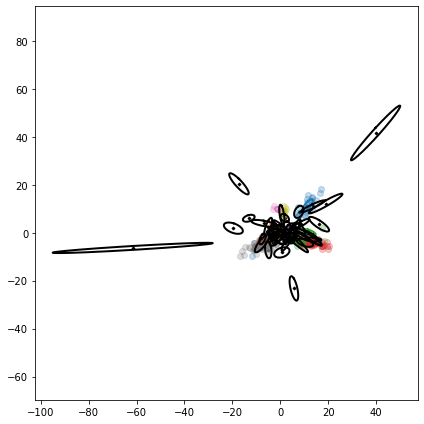

In [32]:
from pybasicbayes.util.plot import plot_gaussian_2D

plt.figure(figsize=(6, 6))
for z in np.unique(parents):
    inds = np.where(parents == z)[0]
    h = plt.plot(data[inds, 2], data[inds, 3], 'o' if z >= 0 else 'ko', alpha=0.25)[0]
    if z >= 0:
        plot_gaussian_2D(clusters[z].mark_cluster.params[0][:2], 
                         clusters[z].mark_cluster.params[1][:2, :2],
                         color=h.get_color())


for c in rjmcmc_samples[-1000]["clusters"]:
    plot_gaussian_2D(c.mark_cluster.params[0][:2], 
                     c.mark_cluster.params[1][:2, :2], 
                     color='k')
    
plt.axis('equal')
plt.tight_layout()

# Debug

In [16]:
# k = int(mu)
# k_smpls = [k]
# n_smpls = 20000
# for i in range(n_smpls):
#     move = npr.rand() < 0.5
#     if move == 1:
#         p_acc = mu / (k + 1)
#         if npr.rand() < p_acc:
#             k += 1
            
#     else:
#         # remove
#         p_acc = k / mu
#         if npr.rand() < p_acc:
#             k -= 1
            
#     k_smpls.append(k)
    
# plt.figure()
# plt.plot(k_smpls)
# plt.plot(mu * np.ones(n_smpls), '--')

# from scipy.stats import poisson
# plt.figure()
# plt.hist(k_smpls, density=True)
# plt.plot(np.arange(2 * mu), poisson.pmf(np.arange(2 * mu), mu))

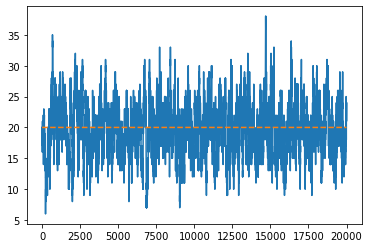

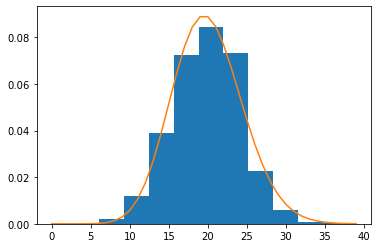

In [17]:
# k = int(mu)
# k_smpls = [k]
# n_smpls = 20000
# for i in range(n_smpls):
#     move = npr.rand() < 0.5
#     if move == 1:
#         p_acc = mu / (k + 1)
#         if npr.rand() < p_acc:
#             k += 1
            
#     else:
#         # remove
#         p_acc = k / mu
#         if npr.rand() < p_acc:
#             k -= 1
            
#     k_smpls.append(k)
    
# plt.figure()
# plt.plot(k_smpls)
# plt.plot(mu * np.ones(n_smpls), '--')

# from scipy.stats import poisson
# plt.figure()
# plt.hist(k_smpls, density=True)
# plt.plot(np.arange(2 * mu), poisson.pmf(np.arange(2 * mu), mu))